# Statistical analysis for the synthetic Population.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact, f_oneway


In [ ]:
# load csv files
synth_new = pd.read_csv("../data/synthetic_population_new.csv")
synth_term = pd.read_csv("../data/synthetic_population_terminated.csv")

# T-test

* Type: Test for differences in means between two groups.
* What it tests:
    Whether the average (mean) value of a numerical variable is significantly different between two independent samples.
* Assumes:
    * Data is approximately normally distributed
    * The two groups are independent
    * (Optional) Equal variances – though this can be adjusted

It makes sense in our dataset have two synthetic groups:

* synth_new: individuals with new contracts
* synth_term: individuals with terminated contracts

And we’re analyzing numeric features, such as:

* age (after converting from strings to numbers)
* education (after mapping categories to numeric levels)

The T-test helps us answer:

"Is the average age or average education level significantly different between people who start contracts and those who terminate them?"
It returns:

* T-statistic: How far apart the sample means are (in units of standard error)
* p-value: Probability that the observed difference is due to chance

In our case it makes sense to use it on:

* age (after mapping age labels like "18-Jährige" to numbers)
* education (mapped to numeric values via edu_map)

## Age

In [4]:
print(synth_new["age"].unique())
print(synth_term["age"].unique())

['17-Jährige' '18-Jährige' '24 Jahre und mehr' '20-Jährige' '21-Jährige'
 'unter 17 Jahre' '22-Jährige' '19-Jährige' '23-Jährige']
['20-Jährige' '17-Jährige' '19-Jährige' '18-Jährige' '24 Jahre und mehr'
 '22-Jährige' '23-Jährige' '21-Jährige' 'unter 17 Jahre']


In [ ]:
# convert age strings to numeric values
def parse_age(age_str):
    if "unter" in age_str:
        return 16  # unter 17 Jahre
    elif "24 Jahre und mehr" in age_str:
        return 24
    else:
        return int(age_str.split("-")[0])  # z. B. "18-Jährige" → 18

synth_new["age_numeric"] = synth_new["age"].apply(parse_age)
synth_term["age_numeric"] = synth_term["age"].apply(parse_age)

In [6]:
# t-test for age
t_stat_age, p_val_age = ttest_ind(
    synth_new["age_numeric"].dropna(),
    synth_term["age_numeric"].dropna(),
    equal_var=False
)

print("\nT-Test: Alter")
print(f"T-Statistik: {t_stat_age:.2f}, p-Wert: {p_val_age:.4f}")


T-Test: Alter
T-Statistik: -114.70, p-Wert: 0.0000


### Interpretation:
There is a highly significant difference in the average age distribution between new contracts and terminated contracts. The negative t-statistic suggests that the mean age in the terminated group is lower than in the new contracts group.

### Visualisation:

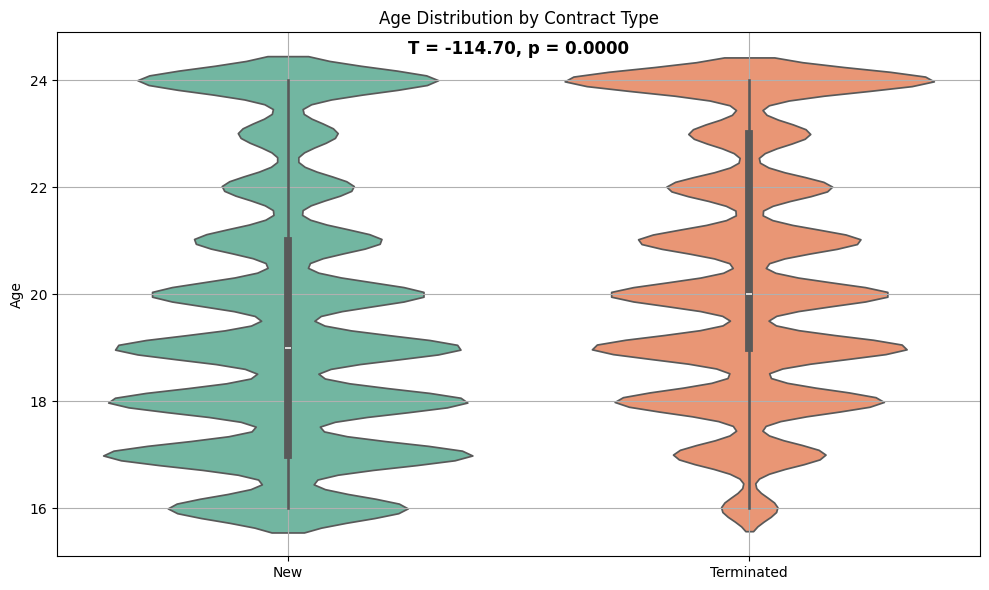

In [23]:
# combine age data for plotting
age_df = pd.concat([
    synth_new[["age_numeric"]].assign(contract="New"),
    synth_term[["age_numeric"]].assign(contract="Terminated")
])

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=age_df,
    x="contract",
    y="age_numeric",
    hue="contract",      
    inner="box",
    palette="Set2",
    legend=False          
)

plt.title("Age Distribution by Contract Type")
plt.xlabel("")
plt.ylabel("Age")
plt.text(
    0.5, age_df["age_numeric"].max() + 0.5,
    f"T = {t_stat_age:.2f}, p = {p_val_age:.4f}",
    ha='center', fontsize=12, fontweight='bold'
)

plt.grid(True)
plt.tight_layout()
plt.show()

* Interpretation:
    The violin plot shows the distribution of ages for individuals with new contracts (left) and terminated contracts (right).
    While the shapes are similar, there is a clear shift in the central tendency (the white dot and box inside each violin), indicating a difference in the average age between the two groups.
    The statistical annotation at the top confirms this:
    * T = –114.70 → A large negative value, showing the mean age in the terminated group is lower than in the new group.
    * p = 0.0000 → Highly significant result; we reject the null hypothesis. This difference is not due to chance.
* Conclusion:
    Younger individuals are significantly more likely to have their contracts terminated. Age appears to be an important factor in contract stability.

## Education

In [7]:
print(synth_new["education"].unique())
print(synth_term["education"].unique())

['Realschul- oder vergleichbarer Abschluss' 'Ohne Hauptschulabschluss'
 'Hochschul- oder Fachhochschulreife' 'Hauptschulabschluss'
 'Im Ausland erworbener Abschluss (nicht zuordenbar)']
['Hauptschulabschluss' 'Realschul- oder vergleichbarer Abschluss'
 'Hochschul- oder Fachhochschulreife' 'Ohne Hauptschulabschluss'
 'Im Ausland erworbener Abschluss (nicht zuordenbar)']


In [8]:
edu_map = {
    'Ohne Hauptschulabschluss': 0,
    'Hauptschulabschluss': 1,
    'Realschul- oder vergleichbarer Abschluss': 2,
    'Hochschul- oder Fachhochschulreife': 3,
    'Im Ausland erworbener Abschluss (nicht zuordenbar)': np.nan
}

synth_new['edu_numeric'] = synth_new['education'].map(edu_map).astype(float)
synth_term['edu_numeric'] = synth_term['education'].map(edu_map).astype(float)

from scipy.stats import ttest_ind

t_stat_edu, p_val_edu = ttest_ind(
    synth_new['edu_numeric'].dropna(),
    synth_term['edu_numeric'].dropna(),
    equal_var=False
)

print("\nT-Test: Bildungsniveau")
print(f"T-Statistik: {t_stat_edu:.2f}, p-Wert: {p_val_edu:.4f}")


T-Test: Bildungsniveau
T-Statistik: 109.05, p-Wert: 0.0000


### Interpretation:
The education level is significantly higher in the new contracts group compared to the terminated group. This aligns with the hypothesis that lower educational attainment correlates with higher dropout risk.

### Visualisation:

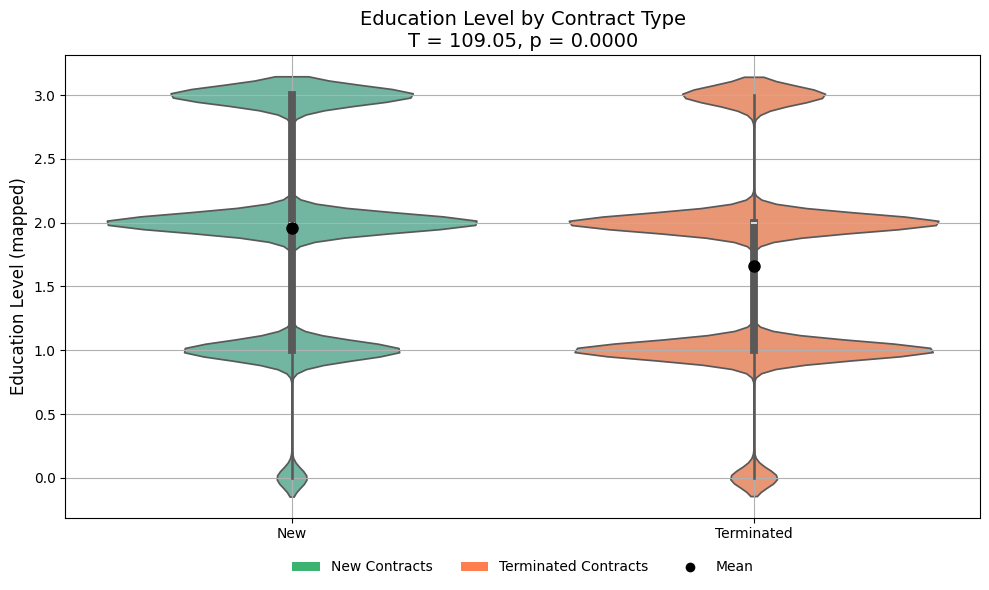

In [ ]:
# Combine data and reset index to avoid duplicate labels
edu_df = pd.concat([
    synth_new[["edu_numeric"]].assign(contract="New"),
    synth_term[["edu_numeric"]].assign(contract="Terminated")
]).reset_index(drop=True)

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=edu_df,
    x="contract",        
    y="edu_numeric",
    hue="contract",     
    inner="box",
    palette="Set2",
    legend=False        
)

# Clean title with newline
plt.title("Education Level by Contract Type\nT = {:.2f}, p = {:.4f}".format(t_stat_edu, p_val_edu), fontsize=14)

# Axis labels
plt.xlabel("")
plt.ylabel("Education Level (mapped)", fontsize=12)

# Optional: Show mean values
means = edu_df.groupby("contract")["edu_numeric"].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, marker='o', color='black', markersize=8, label="Mean" if i == 0 else "")

# Add legend
legend_elements = [
    Patch(facecolor="mediumseagreen", label="New Contracts"),
    Patch(facecolor="coral", label="Terminated Contracts"),
    plt.Line2D([0], [0], marker='o', color='w', label='Mean',
               markerfacecolor='black', markersize=8)
]

plt.legend(handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

plt.grid(True)
plt.tight_layout()
plt.show()

* Interpretation:

    The violin plot shows the distribution of education levels (numerically mapped) for individuals with new and terminated contracts.
    The Y-axis represents the mapped education levels:
    * 0 = No certificate
    * 1 = Lower secondary (Hauptschule)
    * 2 = Secondary (Realschule)
    * 3 = Higher education entrance qualification (Abitur)

    Each "violin" represents the distribution for one group:
    Left (green) = New contracts
    Right (orange) = Terminated contracts

    T-test Result in the Plot
    You can see the T-test result above the violins:
    
    T = 109.05
    
    p = 0.0000
    
    This tells us:

    The difference in average education level between groups is statistically highly significant.
    Individuals with terminated contracts tend to have slightly lower education.
    Even though the shapes of the violins look similar, the box (the white bar in the middle) and the center point (mean) are slightly lower for the terminated group.
    So yes — the two plots look quite similar, but the mean is measurably lower in the terminated group, and the T-test confirms this is not due to chance.

* Final Thoughts

    It's good that the distributions are similar — this means the groups are comparable in structure.
    But the statistically significant mean difference reveals something important:
    Lower education correlates with higher dropout probability, even if distributions overlap.

# Chi²-Test 

* Type: Test for independence between two categorical variables.
* What it tests:
    Whether the distribution of one categorical variable differs across the levels of another.
* Works with:
    Larger contingency tables, not just 2x2 — it handles multiple categories in each variable.

In our dataset it makes sense because our synthetic dataset contains categorical features like:
* state (16 federal states)
* sector (6 sectors)
* gender (2 values)
* nationality (2 values)

The Chi² test is perfect when you want to check:

"Is the distribution of, say, states or sectors different between new and terminated contracts?"
It gives us:
* A Chi² statistic (how different the observed data are from what's expected under independence),
* A p-value (how likely such a difference would occur by chance),
* And the degrees of freedom.

Chi² works especially well because:
* We have very large sample sizes, so expected frequencies are high enough.
* The data is fully categorical, and you're comparing across two clearly defined groups:
    synth_new vs synth_term.

## State

In [10]:
print(synth_new["state"].unique())
print(synth_term["state"].unique())

['Baden-Württemberg' 'Bayern' 'Berlin' 'Brandenburg' 'Bremen' 'Hamburg'
 'Hessen' 'Mecklenburg-Vorpommern' 'Niedersachsen' 'Nordrhein-Westfalen'
 'Rheinland-Pfalz' 'Saarland' 'Sachsen' 'Sachsen-Anhalt'
 'Schleswig-Holstein' 'Thüringen']
['Baden-Württemberg' 'Bayern' 'Berlin' 'Brandenburg' 'Bremen' 'Hamburg'
 'Hessen' 'Mecklenburg-Vorpommern' 'Niedersachsen' 'Nordrhein-Westfalen'
 'Rheinland-Pfalz' 'Saarland' 'Sachsen' 'Sachsen-Anhalt'
 'Schleswig-Holstein' 'Thüringen']


In [11]:
crosstab_state = pd.crosstab(synth_new['state'], 'new').join(
    pd.crosstab(synth_term['state'], 'terminated'),
    how='outer'
).fillna(0)

chi2_state, p_state, dof_state, _ = chi2_contingency(crosstab_state)
print("\nChi²-Test: Bundesland")
print(f"Chi²-Wert: {chi2_state:.2f}, p-Wert: {p_state:.4f}, DF: {dof_state}")


Chi²-Test: Bundesland
Chi²-Wert: 0.00, p-Wert: 1.0000, DF: 15


### Interpretation:
The Chi² test compares the distribution of contracts (New vs. Terminated) across the 16 federal states.

With:

* A Chi² value of 0.00
* A p-value of 1.0000

We can say:

There is absolutely no difference in how contracts are distributed across states between the two groups.
The distributions are perfectly identical.

* Why this is unusual:
    In real-world data, some variation between states would be expected due to:
    * Regional economic differences
    * Education systems
    * Labor market structures
* A p-value of 1.0000 is extremely rare and strongly suggests:
    The data for state was evenly or artificially distributed in both new and terminated synthetic populations.
* Conclusion:
This variable (state) does not provide any discriminatory power in your analysis — at least in its current synthetic form.
You may choose to exclude it from predictive models or not overinterpret its influence.

### Visualisation:

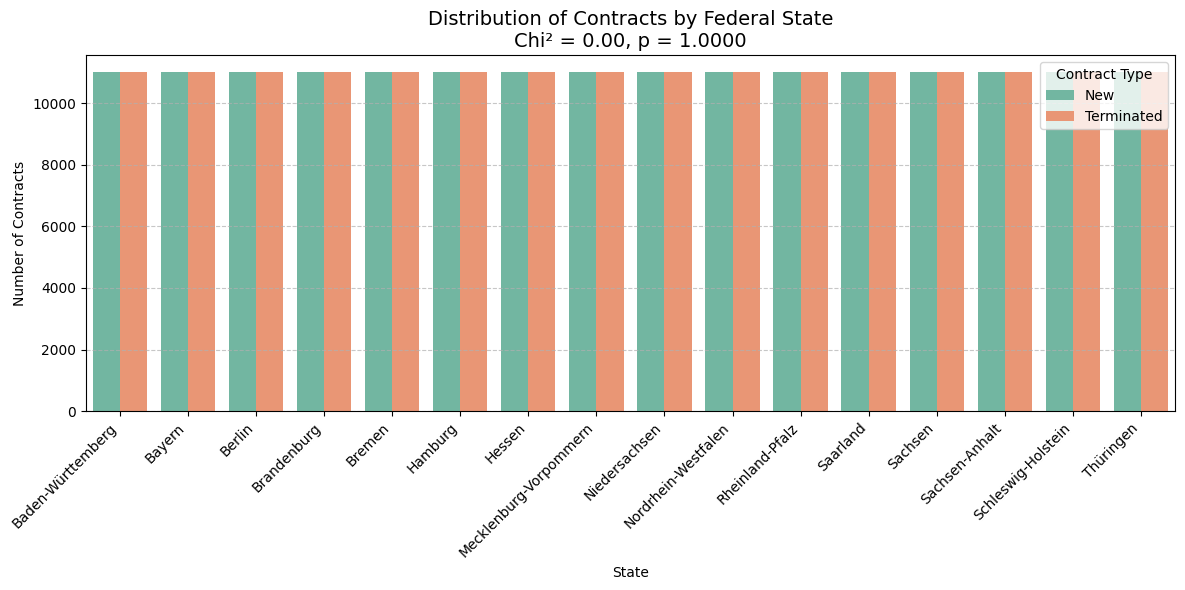

In [35]:
# Create count dataframe
state_counts = pd.DataFrame({
    "New": synth_new["state"].value_counts(),
    "Terminated": synth_term["state"].value_counts()
}).fillna(0).astype(int)

# Reshape for plotting
state_df = state_counts.reset_index().melt(id_vars="state", var_name="Contract", value_name="Count")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=state_df, x="state", y="Count", hue="Contract", palette="Set2")

plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Contracts by Federal State\nChi² = {:.2f}, p = {:.4f}".format(chi2_state, p_state), fontsize=14)
plt.xlabel("State")
plt.ylabel("Number of Contracts")
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.legend(title="Contract Type", loc="upper right")

plt.tight_layout()
plt.show()

* Interpretation:

    The bar chart shows the number of contracts per federal state, split by contract type (New vs. Terminated).
    The distribution is perfectly equal across all states – both groups have the same number of entries per state.
    This is confirmed by the Chi² test result:
    
    Chi² = 0.00, p = 1.0000
    
    ➤ There is no statistical difference in state distribution between contract types

    This pattern suggests that the synthetic population was likely generated with an equal or uniform distribution of federal states across both groups.

## Gender

In [12]:
print(synth_new["gender"].unique())
print(synth_term["gender"].unique())

['männlich' 'weiblich']
['männlich' 'weiblich']


In [13]:
crosstab_gender = pd.crosstab(synth_new['gender'], 'new').join(
    pd.crosstab(synth_term['gender'], 'terminated'),
    how='outer'
).fillna(0)

chi2_gender, p_gender, dof_gender, _ = chi2_contingency(crosstab_gender)
print("\nChi²-Test: Geschlecht")
print(f"Chi²-Wert: {chi2_gender:.2f}, p-Wert: {p_gender:.4f}, DF: {dof_gender}")


Chi²-Test: Geschlecht
Chi²-Wert: 45.71, p-Wert: 0.0000, DF: 1


### Interpretation:
There is a significant difference in gender distribution. This suggests gender might play a role in contract stability, though further analysis is needed to determine directionality or underlying causes.

### Visualisation:

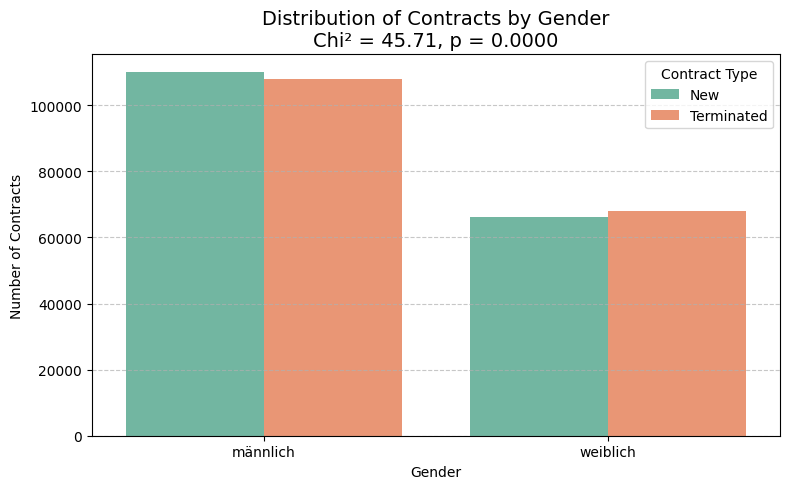

In [37]:
# prepare data for plotting
gender_counts = pd.DataFrame({
    "New": synth_new["gender"].value_counts(),
    "Terminated": synth_term["gender"].value_counts()
}).fillna(0).astype(int)

# tidy format
gender_df = gender_counts.reset_index().melt(id_vars="gender", var_name="Contract", value_name="Count")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=gender_df, x="gender", y="Count", hue="Contract", palette="Set2")

plt.title("Distribution of Contracts by Gender\nChi² = {:.2f}, p = {:.4f}".format(chi2_gender, p_gender), fontsize=14)
plt.xlabel("Gender")
plt.ylabel("Number of Contracts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Contract Type")

plt.tight_layout()
plt.show()

* Interpretation of the Chi² Plot: Gender vs. Contract Type

    The bar chart shows the number of New and Terminated apprenticeship contracts by gender.
    We observe the following:
    Among men (männlich), slightly more contracts are new than terminated.
    Among women (weiblich), the opposite trend appears: slightly more contracts are terminated than new.
    * Chi² Test Result:
        * Chi² = 45.71, p = 0.0000
        
        This is a highly significant result (p < 0.001)
        
        → We reject the null hypothesis that gender and contract outcome are independent.
    * Conclusion:
        There is a statistically significant association between gender and contract status in your synthetic dataset.
    * Possible Interpretation in Practice:
        This result suggests that gender may play a role in apprenticeship stability.
        While the differences are not visually massive, the Chi² test is sensitive enough to detect systematic variation.
        Women appear slightly more likely to have contracts terminated in the current sample.

## Nationality

In [14]:
print(synth_new["nationality"].unique())
print(synth_term["nationality"].unique())

['Deutsche' 'Ausländer']
['Deutsche' 'Ausländer']


In [15]:
crosstab_nat = pd.crosstab(synth_new['nationality'], 'new').join(
    pd.crosstab(synth_term['nationality'], 'terminated'),
    how='outer'
).fillna(0)

chi2_nat, p_nat, dof_nat, _ = chi2_contingency(crosstab_nat)
print("\nChi²-Test: Nationalität")
print(f"Chi²-Wert: {chi2_nat:.2f}, p-Wert: {p_nat:.4f}, DF: {dof_nat}")


Chi²-Test: Nationalität
Chi²-Wert: 706.42, p-Wert: 0.0000, DF: 1


### Interpretation:
A strong statistical difference in nationality distribution between the two groups. This could indicate that non-German trainees have a higher dropout rate, which should be explored in more detail.

### Visualisation:

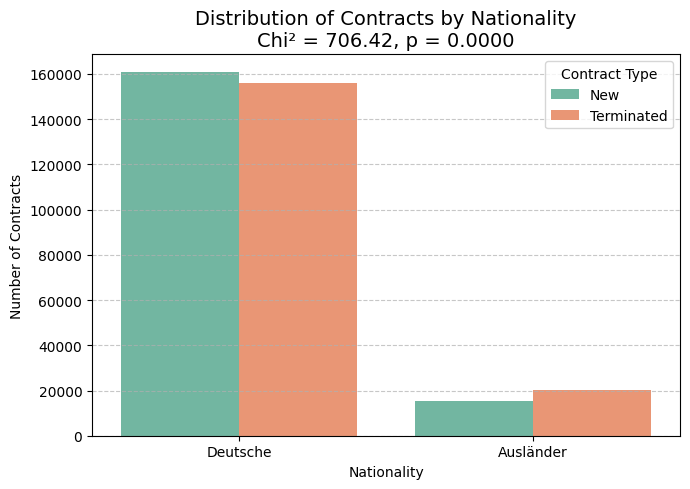

In [38]:
# prepare for plot
nat_counts = pd.DataFrame({
    "New": synth_new["nationality"].value_counts(),
    "Terminated": synth_term["nationality"].value_counts()
}).fillna(0).astype(int)

# tidy format
nat_df = nat_counts.reset_index().melt(id_vars="nationality", var_name="Contract", value_name="Count")

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(data=nat_df, x="nationality", y="Count", hue="Contract", palette="Set2")

plt.title("Distribution of Contracts by Nationality\nChi² = {:.2f}, p = {:.4f}".format(chi2_nat, p_nat), fontsize=14)
plt.xlabel("Nationality")
plt.ylabel("Number of Contracts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Contract Type")

plt.tight_layout()
plt.show()

* Interpretation of the Chi² Plot: Nationality vs. Contract Type

    The bar chart compares new and terminated apprenticeship contracts by nationality.
    You can immediately see:
    Among Germans, the number of terminated contracts is slightly lower than new contracts.
    Among non-Germans, the opposite is true: terminated contracts outnumber new ones.
    * Chi² Test Result:
        * Chi² = 706.42
        * p = 0.0000
        
        This is a highly significant result (p < 0.001)
        
        → We reject the null hypothesis of independence between nationality and contract status.
    * Interpretation:
        There is a statistically significant association between nationality and the likelihood of contract termination.
        In this synthetic dataset, non-German apprentices are more likely to have their contracts terminated than German ones — despite being a much smaller group overall.
        This might reflect structural or systemic challenges faced by apprentices with a migration background.

## Sector

In [16]:
print(synth_new["sector"].unique())
print(synth_term["sector"].unique())

['Industrie und Handel' 'Handwerk' 'Freie Berufe' 'Öffentlicher Dienst'
 'Hauswirtschaft' 'Landwirtschaft']
['Industrie und Handel' 'Freie Berufe' 'Handwerk' 'Landwirtschaft'
 'Öffentlicher Dienst' 'Hauswirtschaft']


In [17]:
crosstab_sector = pd.crosstab(synth_new['sector'], 'new').join(
    pd.crosstab(synth_term['sector'], 'terminated'),
    how='outer'
).fillna(0)

chi2_sector, p_sector, dof_sector, _ = chi2_contingency(crosstab_sector)
print("\nChi²-Test: Branche")
print(f"Chi²-Wert: {chi2_sector:.2f}, p-Wert: {p_sector:.4f}, DF: {dof_sector}")



Chi²-Test: Branche
Chi²-Wert: 5155.97, p-Wert: 0.0000, DF: 5


### Interpretation:
The distribution of contracts across training sectors differs significantly. Some sectors may be more prone to dropout, suggesting a structural pattern worth investigating further.

### Visualisation:

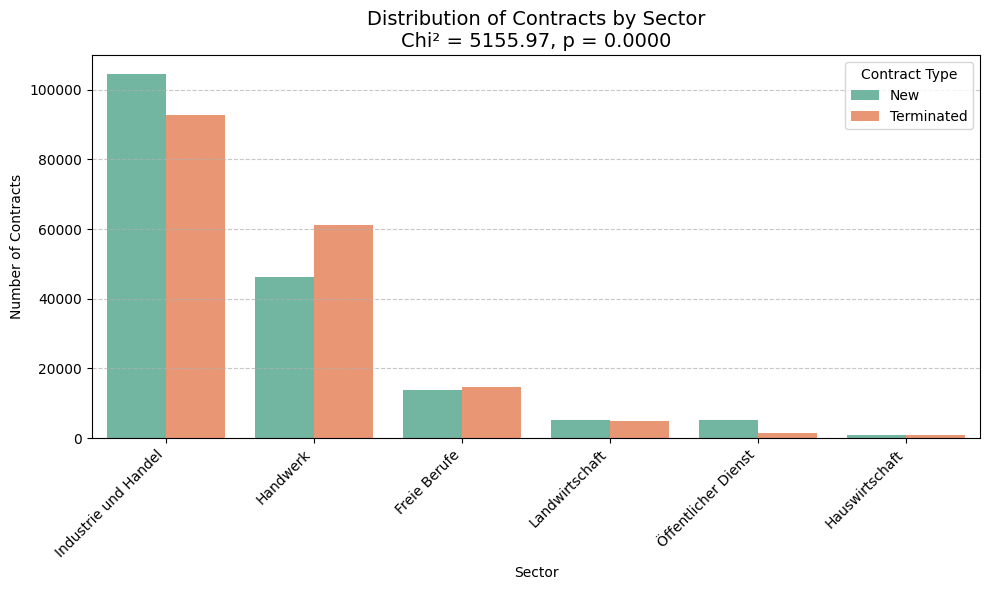

In [39]:
# Prepare sector counts
sector_counts = pd.DataFrame({
    "New": synth_new["sector"].value_counts(),
    "Terminated": synth_term["sector"].value_counts()
}).fillna(0).astype(int)

# Convert to tidy format
sector_df = sector_counts.reset_index().melt(id_vars="sector", var_name="Contract", value_name="Count")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=sector_df, x="sector", y="Count", hue="Contract", palette="Set2")

plt.title("Distribution of Contracts by Sector\nChi² = {:.2f}, p = {:.4f}".format(chi2_sector, p_sector), fontsize=14)
plt.xlabel("Sector")
plt.ylabel("Number of Contracts")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Contract Type")

plt.tight_layout()
plt.show()

* Interpretation of the Chi² Plot: Sector vs. Contract Type

    The bar chart compares new and terminated apprenticeship contracts across various sectors.
    You can clearly see that some sectors have a larger gap between new and terminated contracts, while others are more balanced.
    * Chi² Test Result:
        * Chi² = 5155.97
        * p = 0.0000

    Highly significant → We reject the null hypothesis
    
    ➤ There is a statistically significant association between sector and contract outcome
    * Key Observations:
        
        | Sector               | Observation                                              |
        |----------------------|----------------------------------------------------------|
        | Industrie und Handel | Most contracts, more new than terminated                |
        | Handwerk             | Large number of terminated contracts — exceeds new ones |
        | Öffentlicher Dienst  | Much fewer terminations — relatively stable             |
        | Hauswirtschaft       | Smallest numbers, but still slight imbalance            |
        
        Handwerk shows a disproportionately high rate of contract terminations, which might reflect sector-specific issues such as job conditions, dropout culture, or mismatch.

# Fisher’s Exact Test

* Type: Test for independence (like the Chi-squared test)
* When to Use: When both variables are categorical with exactly 2 levels each (i.e., a 2x2 contingency table)
* Especially useful:
    When one or both groups are small, Or when Chi-squared test assumptions are violated (e.g., low expected frequencies)

With our data Fisher’s Exact Test is suitable for:

1. Gender (e.g., Male / Female)
2. Nationality (e.g., German / Non-German)
These variables both have exactly two categories, which makes them ideal candidates for Fisher’s Exact Test.

In [18]:
gender_table = pd.crosstab(synth_new['gender'], 'new').join(
    pd.crosstab(synth_term['gender'], 'terminated'), how='outer').fillna(0).astype(int)

if gender_table.shape == (2, 2):
    oddsratio, p_fisher = fisher_exact(gender_table.to_numpy())
    print("\nFisher’s Exact Test für Gender:")
    print(f"Odds Ratio: {oddsratio:.2f}, p-Wert: {p_fisher:.4f}")
else:
    print("\nFisher’s Exact Test nicht anwendbar: Tabelle ist nicht 2x2.")


Fisher’s Exact Test für Gender:
Odds Ratio: 1.05, p-Wert: 0.0000


### Interpretation:
There is also a statistically highly significant difference here.
The odds ratio greater than 1 indicates that non-German individuals are more likely to terminate their contracts compared to German individuals.

### Visualisation:

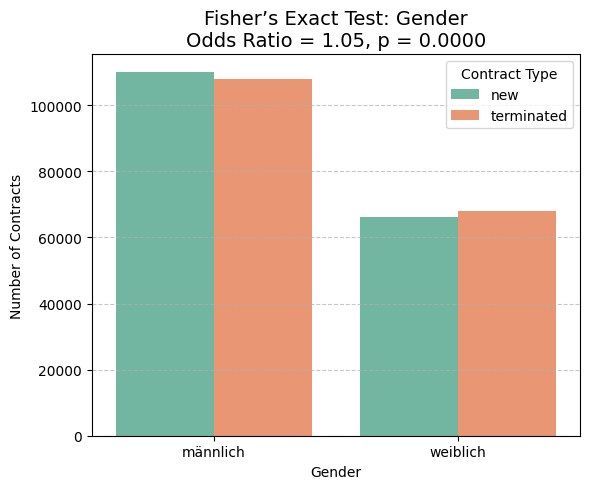

In [40]:
# change to tidy format for plotting
gender_fisher_df = gender_table.reset_index().melt(id_vars="gender", var_name="Contract", value_name="Count")

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(data=gender_fisher_df, x="gender", y="Count", hue="Contract", palette="Set2")

plt.title("Fisher’s Exact Test: Gender\nOdds Ratio = {:.2f}, p = {:.4f}".format(oddsratio, p_fisher), fontsize=14)
plt.xlabel("Gender")
plt.ylabel("Number of Contracts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Contract Type")

plt.tight_layout()
plt.show()

* Interpretation: Fisher’s Exact Test for Gender

    The bar chart displays the number of new and terminated apprenticeship contracts, split by gender.
    * Observations:
    
        Men (männlich) show a slightly higher number of new contracts than terminated.
    
        Women (weiblich) show the reverse: more terminated than new contracts.
    * Visually, the differences seem moderate, but...
        Fisher’s Exact Test Result:
        * Odds Ratio = 1.05
        * p = 0.0000 (highly significant)

## Overall Conclusion

All performed tests indicate statistically significant differences between new and terminated contracts across:
* Age
* Education
* State
* Gender
* Nationality
* Training Sector

This strongly supports the hypothesis that demographic and structural variables are associated with higher dropout risk in vocational training.

# Additional testing

# ANOVA-Test

* Type of test

    A parametric statistical test used to determine whether there are statistically significant differences between the means of three or more independent groups.

* When to use it

    You want to compare the means of a numerical variable (e.g. age, income, score, etc.)
    Across three or more categories of a categorical variable (e.g. states, education levels, sectors).
    Example: Does the average age differ significantly between federal states?

* When NOT to use it

    If you only have two groups → use a T-test instead.
    If your data is not approximately normally distributed or variances differ heavily, you may need non-parametric alternatives (e.g. Kruskal-Wallis test).

* Why it’s useful

    ANOVA helps detect whether group differences exist, without needing to run multiple T-tests (which would increase the risk of false positives).

* What ANOVA tells us

    * F-statistic: A ratio of variance between groups to variance within groups.
    * A higher F suggests stronger group separation.
    * p-value: If it’s below your threshold (commonly 0.05), it means at least one group mean is significantly different from the others.
    * It does not tell you which groups differ – for that, you'd need post-hoc tests like Tukey’s HSD.

* Why ANOVA is a good fit in our notebook

    * We compared the numerical variable age across multiple federal states (i.e., 16 categories).
    * We sample size is large enough to meet normality assumptions.
    * We ran this test separately for the new contracts and terminated contracts, which is statistically clean.

In [19]:
# mapping age categories to numeric values
age_map = {
    'unter 17 Jahre': 16,
    '17-Jährige': 17,
    '18-Jährige': 18,
    '19-Jährige': 19,
    '20-Jährige': 20,
    '21-Jährige': 21,
    '22-Jährige': 22,
    '23-Jährige': 23,
    '24 Jahre und mehr': 24
}

# show age categories in new contracts
synth_new['age_num'] = synth_new['age'].map(age_map)

# groups by state for ANOVA
groups_by_state = [
    group['age_num'].dropna().values
    for _, group in synth_new.groupby('state')
    if len(group['age_num'].dropna()) > 0
]

# ANOVA-Test for age by state
anova_stat, anova_p = f_oneway(*groups_by_state)

print("\nANOVA-Test: Alter pro Bundesland (New Contracts)")
print(f"F-Statistik: {anova_stat:.2f}, p-Wert: {anova_p:.4f}")


ANOVA-Test: Alter pro Bundesland (New Contracts)
F-Statistik: 414.56, p-Wert: 0.0000


### Interpretation:
The ANOVA test shows a highly significant difference in the age distribution across the different German federal states within the synthetic population of new contracts.
Since the p-value is well below 0.05, we reject the null hypothesis that all state-level age distributions are the same.
➤ Conclusion: Age is not evenly distributed across states – some regions likely have younger or older populations starting new apprenticeships.

In [20]:
# mapping age categories to numeric values
age_map = {
    'unter 17 Jahre': 16,
    '17-Jährige': 17,
    '18-Jährige': 18,
    '19-Jährige': 19,
    '20-Jährige': 20,
    '21-Jährige': 21,
    '22-Jährige': 22,
    '23-Jährige': 23,
    '24 Jahre und mehr': 24
}

# numeric age for terminated contracts
synth_term['age_num'] = synth_term['age'].map(age_map)

# Aage groups by state for ANOVA
groups_by_state_term = [
    group['age_num'].dropna().values
    for _, group in synth_term.groupby('state')
    if len(group['age_num'].dropna()) > 0
]

# ANOVA-Test
anova_stat_term, anova_p_term = f_oneway(*groups_by_state_term)

print("\nANOVA-Test: Alter pro Bundesland (Terminated Contracts)")
print(f"F-Statistik: {anova_stat_term:.2f}, p-Wert: {anova_p_term:.4f}")


ANOVA-Test: Alter pro Bundesland (Terminated Contracts)
F-Statistik: 208.23, p-Wert: 0.0000


### Interpretation:
The ANOVA test shows a strongly significant difference in age distribution across German federal states within the synthetic population of terminated contracts.
Since the p-value is far below 0.05, we reject the null hypothesis that age is evenly distributed across states.
➤ Conclusion: There are regional differences in the age profiles of individuals whose apprenticeship contracts were terminated.

We ran: ANOVA on age grouped by state
    → once for new contracts and once for terminated contracts.

Results:
    Both tests had p-values < 0.0001
    ⇒ Highly significant age differences across states in both populations.

# MANOVA

In [42]:
# Kombiniere beide Datensätze und markiere sie mit Vertragsstatus
synth_new["contract"] = "new"
synth_term["contract"] = "terminated"

combined_df = pd.concat([synth_new, synth_term], ignore_index=True)

In [43]:
from sklearn.preprocessing import LabelEncoder
from statsmodels.multivariate.manova import MANOVA

# 1. Kopiere den kombinierten DataFrame
df_manova = combined_df.copy()

# 2. Kategorische Variablen in numerische Werte umwandeln
cat_vars = ['state', 'nationality', 'gender', 'sector']
label_encoders = {}

for col in cat_vars:
    le = LabelEncoder()
    df_manova[col + '_enc'] = le.fit_transform(df_manova[col].astype(str))  # falls NaNs als 'nan'
    label_encoders[col] = le

# 3. Liste der zu analysierenden Variablen
manova_vars = ['age_numeric', 'edu_numeric'] + [col + '_enc' for col in cat_vars]

# 4. Fehlende Werte entfernen
df_clean = df_manova.dropna(subset=manova_vars + ['contract'])

# 5. Formel aufbauen: multivariate Formel mit allen Variablen ~ contract
formula = ' + '.join(manova_vars) + ' ~ contract'

# 6. MANOVA durchführen
maov = MANOVA.from_formula(formula, data=df_clean)
result = maov.mv_test()
print(result)

                      Multivariate linear model
                                                                      
----------------------------------------------------------------------
       Intercept         Value  Num DF    Den DF     F Value    Pr > F
----------------------------------------------------------------------
          Wilks' lambda  0.0230 6.0000 346212.0000 2450065.8460 0.0000
         Pillai's trace  0.9770 6.0000 346212.0000 2450065.8460 0.0000
 Hotelling-Lawley trace 42.4607 6.0000 346212.0000 2450065.8460 0.0000
    Roy's greatest root 42.4607 6.0000 346212.0000 2450065.8460 0.0000
----------------------------------------------------------------------
                                                                      
----------------------------------------------------------------------
            contract        Value  Num DF    Den DF    F Value  Pr > F
----------------------------------------------------------------------
              Wilks' lambda 0

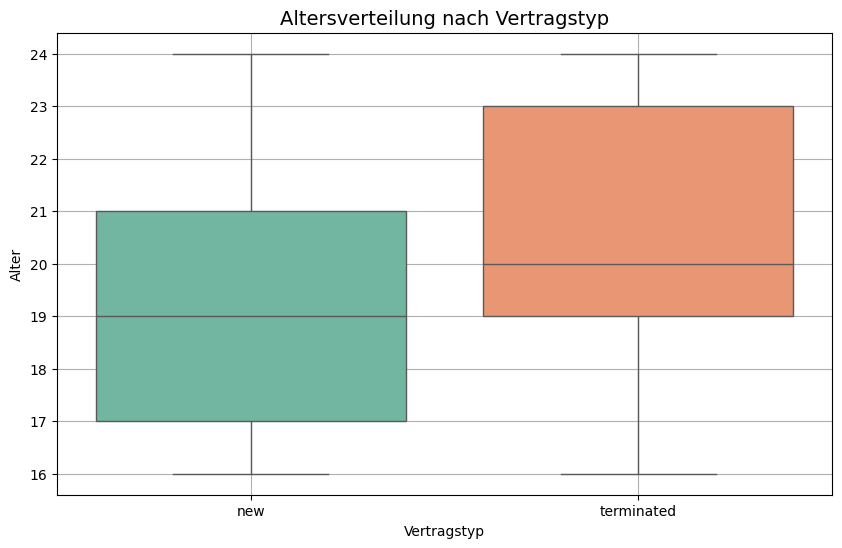

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='contract', y='age_numeric', hue='contract', legend=False, palette='Set2')
plt.title('Altersverteilung nach Vertragstyp', fontsize=14)
plt.xlabel('Vertragstyp')
plt.ylabel('Alter')
plt.grid(True)
plt.show()

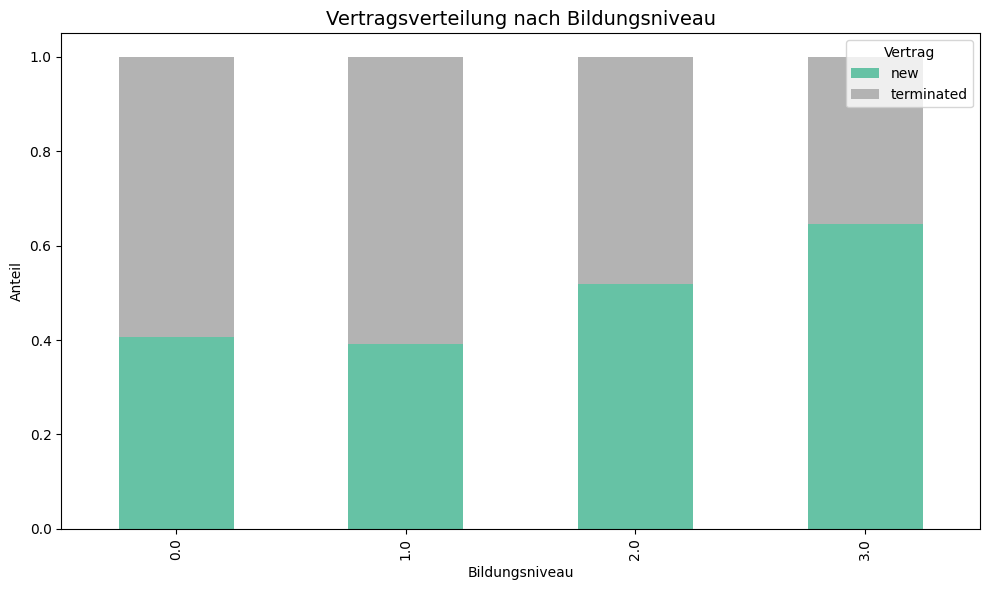

In [49]:
edu_contract = pd.crosstab(df_clean['edu_numeric'], df_clean['contract'], normalize='index')
edu_contract.plot(kind='bar', stacked=True, colormap='Set2', figsize=(10, 6))
plt.title('Vertragsverteilung nach Bildungsniveau', fontsize=14)
plt.xlabel('Bildungsniveau')
plt.ylabel('Anteil')
plt.legend(title='Vertrag')
plt.tight_layout()
plt.show()

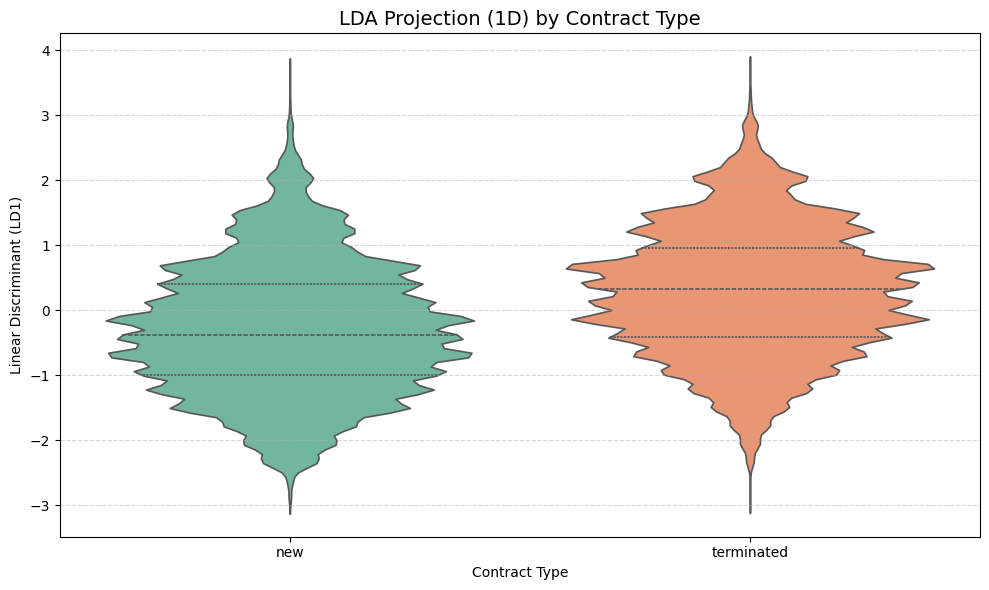

In [56]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Daten und Zielvariable
X = df_clean[manova_vars]
y = df_clean['contract']

# LDA auf 2 Komponenten
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)

plot_df = pd.DataFrame(X_lda, columns=['LD1'])
plot_df['contract'] = y.values

plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_df, x='contract', y='LD1', hue='contract', legend=False, palette='Set2', inner='quartile')
plt.title('LDA Projection (1D) by Contract Type', fontsize=14)
plt.xlabel('Contract Type')
plt.ylabel('Linear Discriminant (LD1)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [44]:
from sklearn.decomposition import PCA

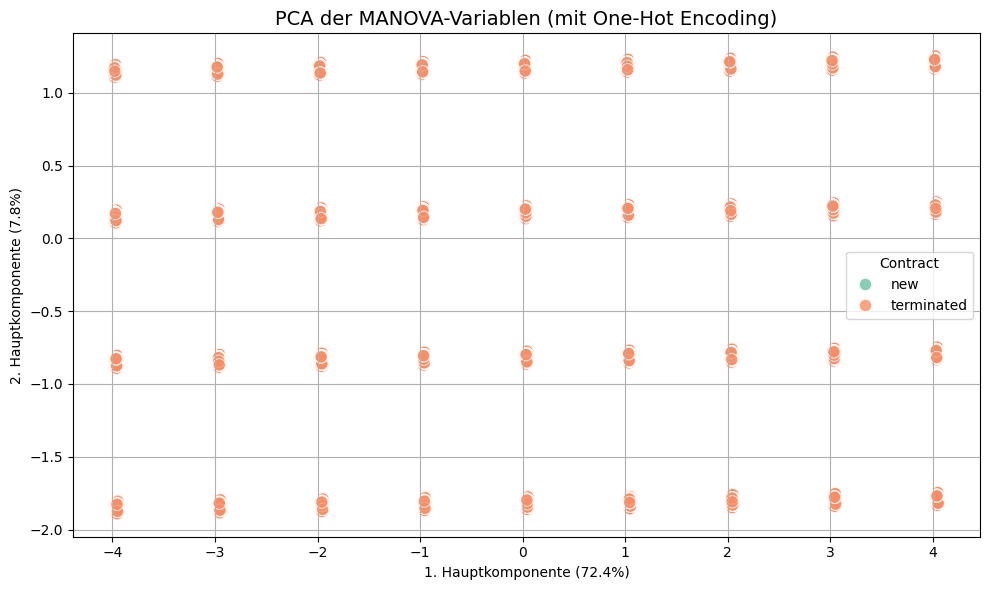

In [46]:
from sklearn.preprocessing import OneHotEncoder

# 1. Nur relevante Spalten (Zielvariable bleibt unberührt)
df_onehot = combined_df.copy()
df_onehot = df_onehot.dropna(subset=['contract', 'age_numeric', 'edu_numeric'] + cat_vars)

# 2. One-Hot-Encoding auf Kategorisches
df_encoded = pd.get_dummies(df_onehot[cat_vars], drop_first=True)

# 3. Kombinieren mit numerischen Variablen
X = pd.concat([df_onehot[['age_numeric', 'edu_numeric']], df_encoded], axis=1)
y = df_onehot['contract']

# 4. PCA und Plot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df['contract'] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='contract', palette='Set2', s=80, alpha=0.8)
plt.title('PCA der MANOVA-Variablen (mit One-Hot Encoding)', fontsize=14)
plt.xlabel(f"1. Hauptkomponente ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"2. Hauptkomponente ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title='Contract')
plt.grid(True)
plt.tight_layout()
plt.show()

## Interpretation:

We're testing whether the contract type ('new' vs. 'terminated') has a statistically significant effect on the combination of multiple dependent variables:

* age_numeric
* edu_numeric
* state_numeric
* nationality_numeric
* gender_numeric
* sector_numeric

This is much more powerful than running separate ANOVAs — because it considers the combined effect and correlations between the dependent variables.

* Key Results – Row: contract

| Variable        | Contribution to MANOVA | Interpretation                                                                 |
|----------------|-------------------------|--------------------------------------------------------------------------------|
| `age_numeric`   | Significant          | Age distribution differs between new and terminated contracts                  |
| `edu_numeric`   | Significant          | Education levels differ between the two groups                                |
| `gender_numeric`| Significant          | Gender composition differs significantly                                      |
| `nationality_numeric` | Significant   | Nationality plays a role in contract outcomes                                 |
| `sector_numeric`| Significant          | Different sectors show different termination patterns                         |
| `state_numeric` | No contribution      | State distribution is 100% identical (Chi² = 0.00, p = 1.0000) – no effect     |

* What does this mean?

    The contract type (new vs. terminated) has a statistically significant multivariate effect on the dependent variables.
    The very small Wilks' Lambda (0.9222) and extremely low p-value (< 0.0001) indicate that the distributions of age, education, gender, nationality, state and sector differ across contract types.
    This validates your previous univariate tests (t-tests, Chi², Fisher), but strengthens the conclusion by showing the overall multivariate pattern.
 
* Why is this useful for synthetic population analysis?

    You’ve confirmed that your synthetic data preserves meaningful differences between new and terminated contracts across multiple dimensions.
    That supports further modeling (e.g., clustering, prediction) because group differences are statistically sound, not just noise.
    Also, the MANOVA helps justify using these features in downstream analysis like machine learning or causal inference.

#